# Logistic Regression

In [39]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

In [3]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Divide Columns

In [4]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [5]:
score_dict = {}
def print_scores():
    for key in score_dict.keys():
        print(f'{key}, f1_micro_score: {round(score_dict[key][0],4)}, Run time: {round(score_dict[key][1],0)}')

### logreg0:  Basline Logistic Regression with no feature engineering

In [6]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols),
    ('categorical', ohe_pipe, cat_cols),
    ('integer', 'passthrough', integer_cols),
    ('geo', 'passthrough', geo_cols)
])

In [7]:
logreg0_pipe = imbPipeline([
    ('trans', transformer), 
    ('logreg', LogisticRegression(n_jobs=-1, random_state=42))
])

In [8]:
start = time.time()
f1_micro_logreg0 = cross_val_score(logreg0_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_logreg0 = (end-start)

Run time: 78.13385510444641


In [9]:
f1_micro_logreg0 = f1_micro_logreg0.mean()
f1_micro_logreg0

0.5691174213353799

In [10]:
score_dict['logreg0'] = [f1_micro_logreg0, run_time_logreg0]
print_scores()

logreg0, f1_micro_score: 0.5691, Run time: 78.0


Not a great score compared to our Random Forest models.  Let's move on with some feature engineering.

### logreg1: Try normalizing and scaling integer columns and dropping some features

I will drop the same features that I did for the random forest model after checking feature importances.

In [11]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

In [12]:
def log_transform(x):
    return np.log(x+1)

In [13]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', 'passthrough', geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [14]:
logreg1_pipe = imbPipeline([
    ('transformer', transformer),
    ('logreg', LogisticRegression(n_jobs=-1, random_state=42))
])

In [15]:
start = time.time()
f1_micro_logreg1 = cross_val_score(logreg1_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_logreg1 = end-start

Run time: 59.065468072891235


In [16]:
f1_micro_logreg1 = f1_micro_logreg1.mean()
f1_micro_logreg1

0.5723151701202354

In [17]:
score_dict['logreg1'] = [f1_micro_logreg1, run_time_logreg1]
print_scores()

logreg0, f1_micro_score: 0.5691, Run time: 78.0
logreg1, f1_micro_score: 0.5723, Run time: 59.0


This creates a slight improvement.  Let's keep the scaling and normalization and add Target Encoding.

### logreg2:  Try Target Encoding on the previous model

In [18]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [19]:
logreg2_pipe = imbPipeline([
    ('transformer', transformer),
    ('logreg', LogisticRegression(n_jobs=-1, random_state=42))
])

In [20]:
start = time.time()
f1_micro_logreg2 = cross_val_score(logreg2_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_logreg2 = end-start

Run time: 57.024518966674805


In [21]:
f1_micro_logreg2 = f1_micro_logreg2.mean()
f1_micro_logreg2

0.7267587618316704

In [22]:
score_dict['logreg2'] = [f1_micro_logreg2, run_time_logreg2]
print_scores()

logreg0, f1_micro_score: 0.5691, Run time: 78.0
logreg1, f1_micro_score: 0.5723, Run time: 59.0
logreg2, f1_micro_score: 0.7268, Run time: 57.0


Target Encoding greatly improves the model.  In fact, the f1-micro score is similar to the Random Forest models, with less run time.

### logreg3:  Use previous model with SMOTE

In [23]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [24]:
logreg3_pipe = imbPipeline([
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(n_jobs=-1, random_state=42))
])

In [25]:
start = time.time()
f1_micro_logreg3 = cross_val_score(logreg2_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_logreg3 = end-start

Run time: 55.64549922943115


In [26]:
f1_micro_logreg3 = f1_micro_logreg3.mean()
f1_micro_logreg3

0.7267587618316704

In [27]:
score_dict['logreg3'] = [f1_micro_logreg3, run_time_logreg3]
print_scores()

logreg0, f1_micro_score: 0.5691, Run time: 78.0
logreg1, f1_micro_score: 0.5723, Run time: 59.0
logreg2, f1_micro_score: 0.7268, Run time: 57.0
logreg3, f1_micro_score: 0.7268, Run time: 56.0


In [28]:
f1_micro_logreg2 == f1_micro_logreg3

True

Using SMOTE does not change the f1-micro score, so I will not use it going forward.

### Tune the model with GridsearchCV

Let's do a small grid search to see if we can improve the model.  I'll use logreg2 as the estimator, since it's the best model so far. 

In [29]:
start = time.time()
logreg_pipe_grid = {'logreg__C': [1e-3, 1e-2, 1, 1e2],
                   'logreg__solver': ['lbfgs', 'saga']}
logreg_gs = GridSearchCV(estimator=logreg2_pipe, param_grid=logreg_pipe_grid, 
                              scoring='f1_micro', verbose=1, cv=2)
logreg_gs.fit(X_train, y_train)
end = time.time()
print(f'Run time: {end-start}')

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  2.1min finished


Run time: 132.1313660144806


In [30]:
logreg_gs.best_params_

{'logreg__C': 0.01, 'logreg__solver': 'saga'}

In [31]:
logreg_gs.best_score_

0.7227526221540035

### logreg4:  Use the grid searched hyperparameters

I'll use C=.01 and solver='saga'.

In [32]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [33]:
logreg4_pipe = imbPipeline([
    ('transformer', transformer),
    ('logreg', LogisticRegression(C=.01, solver='saga', n_jobs=-1, random_state=42))
])

logreg4_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['has_superstructure_adobe_mud',
                                                   'has_superstructure_mud_mortar_stone',
                                                   'has_superstructure_stone_flag',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_superstructure_timber',
                                                   'has_superstr...
                                                  ['geo_level_1_id',
                                                   'geo_level_2_id',
                                                   'geo_level_3_id']),
   

In [34]:
start = time.time()
f1_micro_logreg4 = cross_val_score(logreg4_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_logreg4 = end-start

Run time: 26.932199239730835


In [35]:
f1_micro_logreg4 = f1_micro_logreg4.mean()
f1_micro_logreg4

0.7273931951905859

In [36]:
score_dict['logreg4'] = [f1_micro_logreg4, run_time_logreg4]
print_scores()

logreg0, f1_micro_score: 0.5691, Run time: 78.0
logreg1, f1_micro_score: 0.5723, Run time: 59.0
logreg2, f1_micro_score: 0.7268, Run time: 57.0
logreg3, f1_micro_score: 0.7268, Run time: 56.0
logreg4, f1_micro_score: 0.7274, Run time: 27.0


While there is only a marginal score improvement, the saga solver does reduce the runtime by about half.  Let's call this the final Logistic Regression Model and check the model's performance on the test set.

### Checking the final model's performance on the test set

In [37]:
logreg4_preds = logreg4_pipe.predict(X_test)
logreg4_test_score = f1_score(y_test, logreg4_preds, average='micro')
logreg4_test_score

0.7305490322481619

While not quite at the level of the Random Forest Classfier, this model performs remarkably well for it's speed.

### Plot confusion matrix and check model's target accuracies

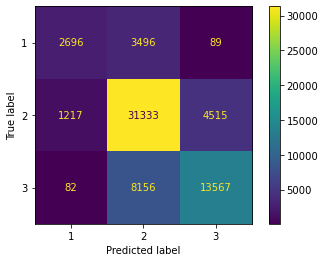

In [41]:
plot_confusion_matrix(logreg4_pipe, X_test, y_test);

In [174]:
cm = confusion_matrix(y_test, gs_preds)
low_damage = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
medium_damage = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
complete_destruction = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 52.78% of low damage.
The model correctly predicts 84.25% of medium damage.
The model correctly predicts 64.4% of complete destruction.
